In [2]:
!ls

sample_data


In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#import path
import sys

In [0]:
plt.style.use('seaborn-notebook')

In [5]:
tf.__version__,pd.__version__

('1.13.0-rc1', '0.22.0')

In [0]:
DATA_DIR='https://raw.githubusercontent.com/rajagurunath/PowerGenForecast/master/data/Formatted_data.csv'
electric_df=pd.read_csv(DATA_DIR,sep=';')

In [7]:
electric_df.head()

,DateTime,Wind Speed,Power Generated,Unnamed: 3
0,02-08-2016 00:00,9.80310,86560.0,NaN
1,02-08-2016 00:15,9.86182,84960.0,NaN
2,02-08-2016 00:30,9.92055,80320.0,NaN
3,02-08-2016 00:45,9.57913,77040.0,NaN
4,02-08-2016 01:00,9.23771,73760.0,NaN


In [0]:
electric_df.set_index(pd.to_datetime(electric_df['DateTime']),inplace=True)

In [9]:
electric_df.iloc[:,:-1].isna().sum()

DateTime              0
Wind Speed         5088
Power Generated       0
dtype: int64

## Ploting

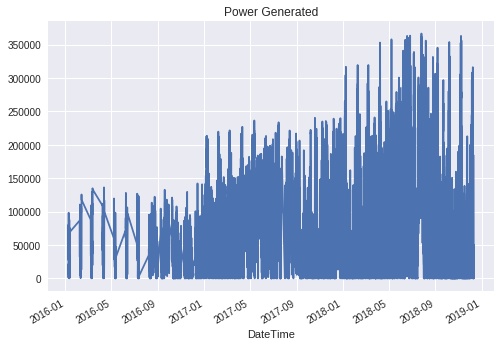

In [10]:
electric_df['Power Generated'].plot(title='Power Generated')
plt.show()

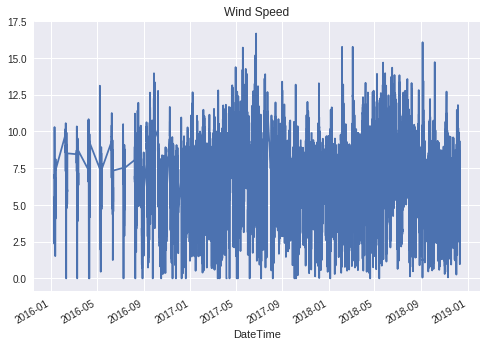

In [11]:
electric_df['Wind Speed'].plot(title='Wind Speed')
plt.show()

# Monthwise

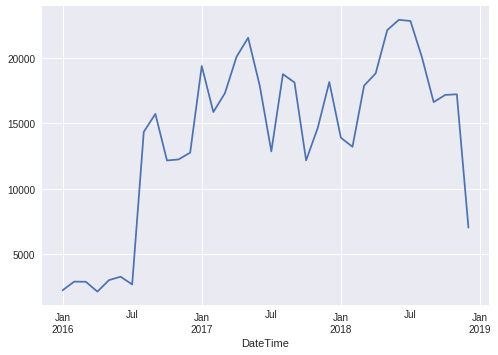

In [12]:
electric_df.resample('1m').sum()['Wind Speed'].plot()

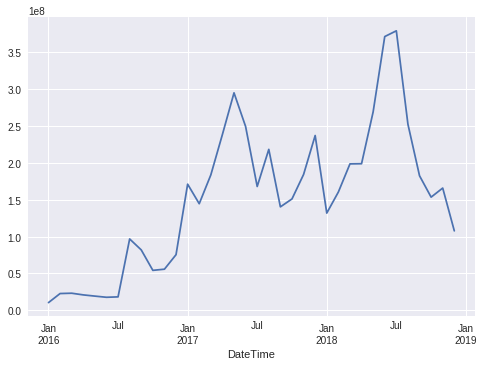

In [13]:
electric_df.resample('1m').sum()['Power Generated'].plot()

# Weekly

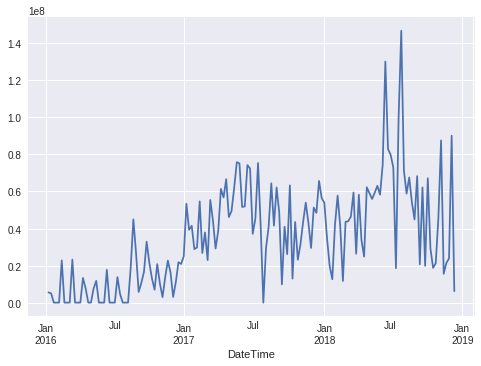

In [14]:
electric_df.resample('1w').sum()['Power Generated'].plot()

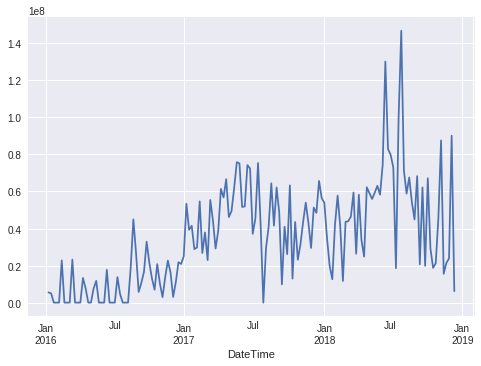

In [15]:
electric_df.resample('1w').sum()['Power Generated'].plot()

# Daywise

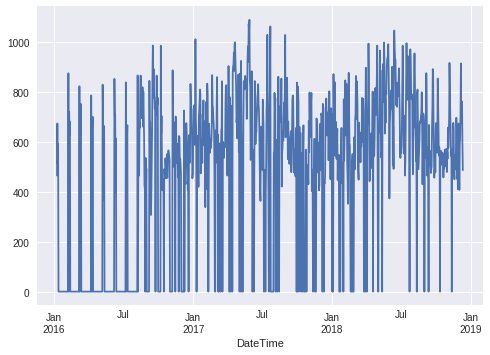

In [16]:
electric_df.resample('1D').sum()['Wind Speed'].plot()

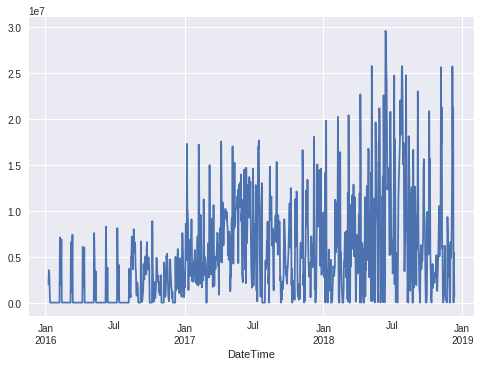

In [17]:
electric_df.resample('1D').sum()['Power Generated'].plot()

# Train -test Split

In [18]:
electric_df['Power Generated'].values.reshape(1,-1)

array([[86560., 84960., 80320., ...,     0.,     0.,     0.]])

In [0]:
from sklearn.preprocessing import StandardScaler,Normalizer
scalar=Normalizer()
electric_df['PowerGenScaled']=scalar.fit_transform(electric_df['Power Generated'].values.reshape(1,-1)).reshape(-1)

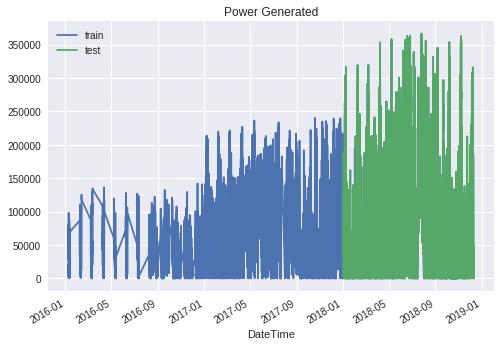

In [20]:
train=electric_df[:'2018-10']
test=electric_df['2018-10':]
train['Power Generated'].plot(label='train')
test['Power Generated'].plot(label='test')
plt.title('Power Generated')
plt.legend()
plt.show()

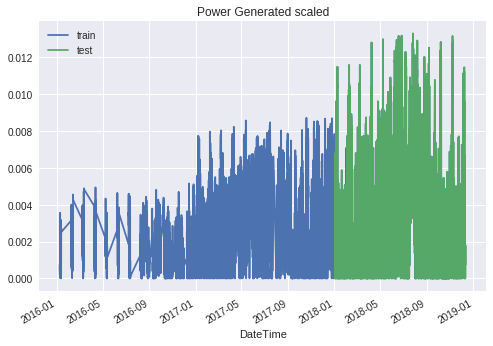

In [21]:
train['PowerGenScaled'].plot(label='train')
test['PowerGenScaled'].plot(label='test')
plt.title('Power Generated scaled')
plt.legend()
plt.show()

# Neural Networks-Model Building

## Approach 1 -Treating power Generated as Sequence

In [0]:
INP_SEQ=192
OUT_SEQ=96 # for one day

In [0]:
array=train['PowerGenScaled'].values
def powerG():
    inp_l=[]
    out_l=[]
    for i in range(array.shape[0]-(INP_SEQ+OUT_SEQ)):
        yield (array[i:i+192].reshape(1,-1),array[i+192:i+192+96].reshape(1,-1))
        
def prepare_data(array):
    print(array.shape)
    inp_l=[]
    out_l=[]
    for i in range(array.shape[0]-(INP_SEQ+OUT_SEQ)):
        inp_l.append(array[i:i+192])
        out_l.append(array[i+192:i+192+96])
    X=np.array(inp_l)
    Y=np.array(out_l)
    return X,Y

In [24]:
X,Y=prepare_data(train['Power Generated'])

(77527,)


ludwigdf=pd.DataFrame({'inp_ts':[X],'out_ts':[Y]},index=range(len(X)))
ludwigdf.to_csv(DIR+'/ludwig_ts.csv')

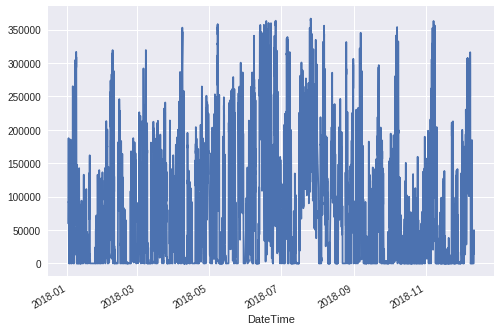

In [25]:
test['Power Generated'][test['Power Generated'].isna()]
test['Power Generated'].plot()

In [0]:
arraytest=test['PowerGenScaled'].values
def powerGtest(use_as_iter=True):
    if use_as_iter:
        for i in range(arraytest.shape[0]-(INP_SEQ+OUT_SEQ)):
            yield (arraytest[i:i+192].reshape(1,-1),arraytest[i+192:i+192+96].reshape(1,-1))
def inference():
    inp_l=[]
    out_l=[]
    for i in range(arraytest.shape[0]-(INP_SEQ+OUT_SEQ)):
        inp_l.append(array[i:i+192])
        out_l.append(array[i+192:i+192+96])
    X=np.array(inp_l)
    Y=np.array(out_l)
    return X,Y
#xt,yt=powerGtest()

In [27]:
dstest=tf.data.Dataset.from_generator(powerGtest,(tf.float64,tf.float64),(tf.TensorShape([1,192]),tf.TensorShape([1,96])))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [0]:
ds=tf.data.Dataset.from_generator(powerG,(tf.float32,tf.float32),(tf.TensorShape([1,192]),tf.TensorShape([1,96])))

In [29]:
value=dstest.make_one_shot_iterator().get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [30]:
sess=tf.Session()
sess.run(value)

(array([[0.00555365, 0.00530689, 0.0051356 , 0.00446499, 0.00375953,
         0.00326019, 0.00306278, 0.00295827, 0.0028886 , 0.00306278,
         0.00315278, 0.00323987, 0.00338793, 0.00366082, 0.00387565,
         0.0039163 , 0.00389598, 0.00392501, 0.00398597, 0.00397146,
         0.00406145, 0.00408468, 0.00395984, 0.00378856, 0.00361147,
         0.00346341, 0.00343148, 0.00340535, 0.00351857, 0.00361728,
         0.0036405 , 0.00366953, 0.00375953, 0.00389307, 0.00391049,
         0.00380888, 0.00341406, 0.00296117, 0.00272602, 0.00255764,
         0.002427  , 0.00259248, 0.00283634, 0.00292924, 0.00296408,
         0.00287408, 0.00271441, 0.00257216, 0.00241249, 0.00208443,
         0.00196831, 0.00191896, 0.00207282, 0.00219185, 0.00219766,
         0.00229926, 0.00245894, 0.00281602, 0.0030773 , 0.003356  ,
         0.00316439, 0.00310633, 0.00318181, 0.00337342, 0.0035418 ,
         0.00361728, 0.00340825, 0.00334438, 0.00327181, 0.00293505,
         0.00245023, 0.0025199 , 0

In [0]:
class RNN(tf.keras.Model):
    def __init__(self, outseq,num_units=192,batch_size=1):
        super().__init__()
        self.outseq = outseq
        self.batch_size=batch_size
        self.cell = tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell',num_units=num_units)
        self.dense = tf.keras.layers.Dense(units=self.outseq)

    def call(self, inputs):
        state = self.cell.zero_state(batch_size=self.batch_size, dtype=tf.float32)
        output,state=self.cell(inputs,state)
        output=self.dense(output)
        return output

In [32]:
lstm=RNN(outseq=96)
lstm.compile('adam',loss='mse')

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


In [33]:
TB=tf.keras.callbacks.TensorBoard('./logs2',histogram_freq=10,write_grads=True,batch_size=32,write_graph=True)
ES=tf.keras.callbacks.EarlyStopping(patience=20)
MC=tf.keras.callbacks.ModelCheckpoint('./lstm2.h5',save_weights_only=True)
#lstm.load_weights('./lstm2.h5')
history=lstm.fit(ds,epochs=10,steps_per_epoch=500,validation_data=dstest,validation_steps=10,callbacks=[ES,MC,TB])

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
500/500 [==============================] - 4s 7ms/step - loss: 4.9225e-07 - val_loss: 1.5145e-06
Epoch 2/10
500/500 [==============================] - 3s 6ms/step - loss: 2.7864e-07 - val_loss: 5.2388e-06
Epoch 3/10
500/500 [==============================] - 3s 5ms/step - loss: 4.4745e-07 - val_loss: 2.8715e-06
Epoch 4/10
500/500 [==============================] - 3s 5ms/step - loss: 4.7299e-07 - val_loss: 3.3555e-06
Epoch 5/10
500/500 [==============================] - 3s 5ms/step - loss: 2.5988e-07 - val_loss: 4.5132e-06
Epoch 6/10
500/500 [==============================] - 3s 5ms/step - loss: 2.0744e-07 - val_loss: 2.2686e-06


In [34]:
!ls

logs2  lstm2.h5  sample_data


# Tensorboard visualization

In [35]:
LOG_DIR = 'logs2'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip


--2019-02-17 06:28:31--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.21.103.149, 52.4.95.48, 52.207.111.186, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.21.103.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.44MB/s    in 0.5s    

2019-02-17 06:28:32 (9.44 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


***Tensorboard link ***

In [36]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://8bd8e788.ngrok.io


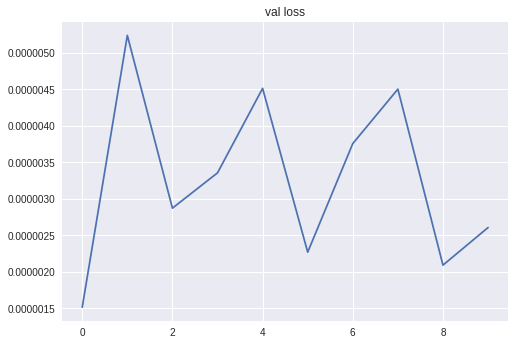

In [37]:
plt.plot(lstm.history.history['val_loss'])
plt.title('val loss')
plt.show()

In [38]:
lstm.evaluate(dstest,steps=1)

1/1 [==============================] - 0s 3ms/step - loss: 3.9444e-06


3.944425316149136e-06

In [0]:
predicted=lstm.predict(dstest,steps=1)

In [40]:
predicted.shape

(1, 96)

# inference or prediction time

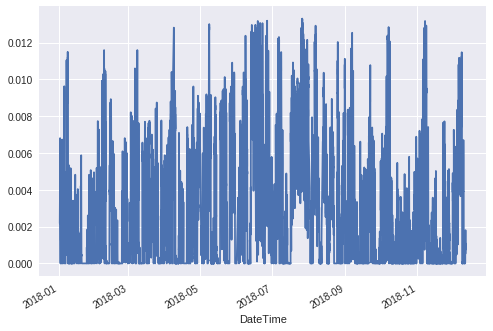

In [41]:
test['PowerGenScaled'].plot()

In [0]:
predicted=lstm.predict_on_batch(dstest)

In [0]:
testiter=dstest.make_one_shot_iterator()
x,y=testiter.get_next()

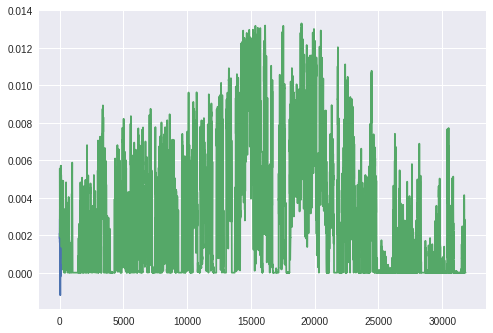

In [44]:
plt.plot(predicted.reshape(-1))
plt.plot(test['PowerGenScaled'].values)
plt.show()

In [0]:
xtest,ytest=inference()
#lstm.predict(X)

In [51]:
xtest.shape,ytest.shape,xtest[0].reshape(1,-1).shape

((31543, 192), (31543, 96), (1, 192))

# *Prediction for last 10 days*

In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error


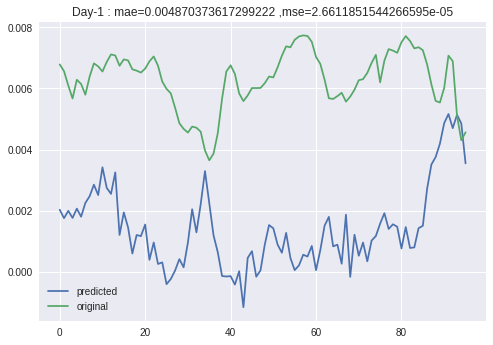

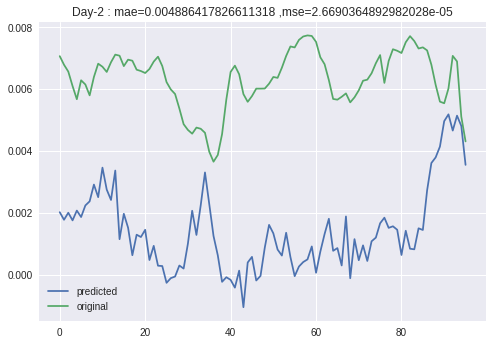

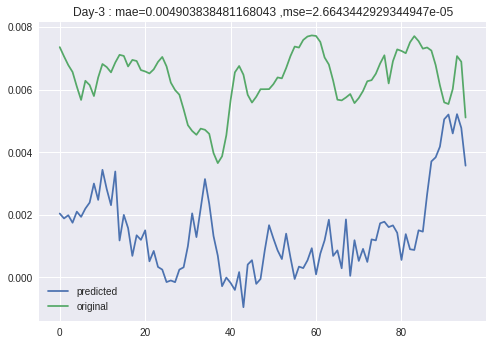

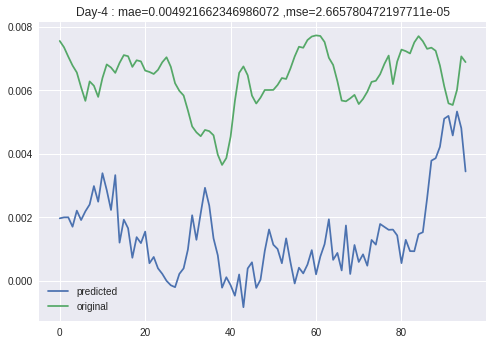

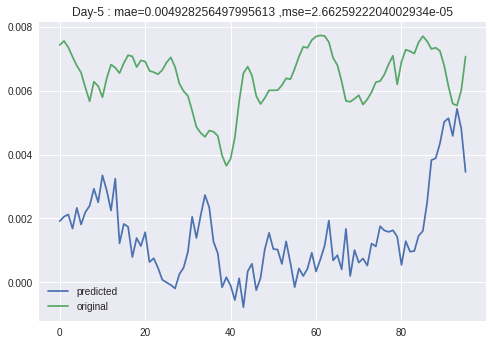

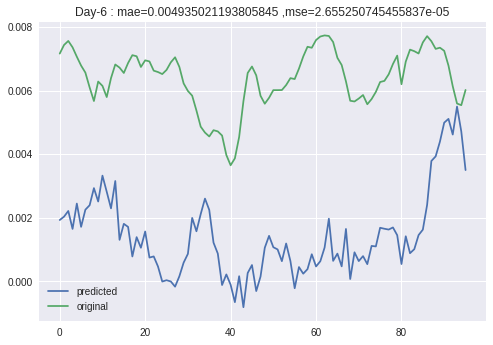

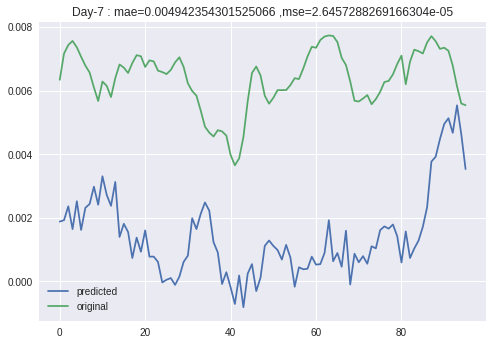

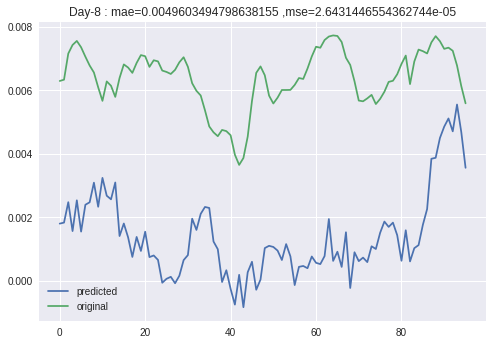

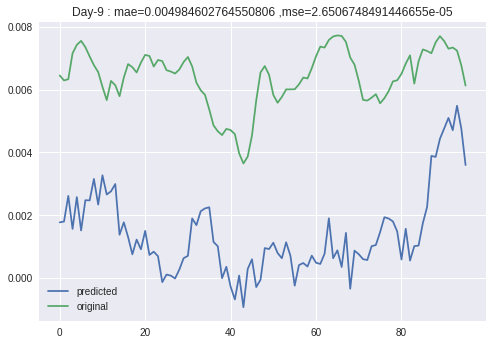

In [68]:
for i in range(1,10):
  ithday=len(xtest)-i
  predicted=lstm.predict(xtest[ithday].reshape(1,-1))
  original=ytest[ithday]
  plt.plot(predicted.reshape(-1),label='predicted')
  plt.plot(original,label='original')
  mae=mean_absolute_error(original,predicted.reshape(-1))
  mse=mean_squared_error(original,predicted.reshape(-1))
  plt.title('Day-{} : mae={} ,mse={}'.format(i,mae,mse))
  plt.legend()
  plt.show()

lstmestimator=tf.keras.estimator.model_to_estimator(keras_model=lstm)